# Web Scraping and Commodity Prices EDA
What's done?
* Using `lxml` to obtain the commodity dates and prices from **[webpages](https://www.investing.com/commodities/gold-historical-data)** and convert to `pandas` dataframe. 
* Create a command line python program using `sys.argv`.
 * program computes stats of commodity prices
* Exploratory Data Analysis (EDA): 
 * Short and long term predictability of commodity prices
 * Stationarity test shows promising results for model (e.g., SARIMA and LSTM) development

# Start Scraping!
Open the webpage and hit `Command`+`Option`+`i`, and move to the price and date elements and right click `Copy` -> `XPath`. The `XPath` is copied and used by `lxml.etree.xpath` to obtain the string values of price and date.

In [56]:
from lxml import etree
import numpy as np
import pandas as pd
from scipy.stats import zscore # zscore=(a - mean(a))/std(a)
import requests # for http requests
from datetime import datetime # change date format
import sys
from statsmodels.tsa.stattools import adfuller # augmented Dickey-Fuller test
def get_commodity_from_investing(commodity_name): # scrape `date` and `price` from investing.com
    url = "https://www.investing.com/commodities/%s-historical-data"%commodity_name
    response = requests.get(url, headers={"User-Agent": "Mozilla/5.0"}) # add User-Agent to prevent 403 error
    html = response.content
    tree = etree.HTML(html)

    rows = len(tree.xpath('/html/body/div[5]/section/div[9]/table[1]/tbody/tr[*]')) # use * to get all table rows 
    price = [0]*rows
    date = ['']*rows
    for i in range(rows):
        date[i] = date_formatting(tree.xpath('/html/body/div[5]/section/div[9]/table[1]/tbody/tr[%s]/td[1]/text()'%str(i+1))[0]) # index 0 to remove the list item
        price[i] = float(tree.xpath('/html/body/div[5]/section/div[9]/table[1]/tbody/tr[%s]/td[2]/text()'%str(i+1))[0].replace(',',''))
    #gold_date_price = list(zip(date,price)) # zip the two lists into one
    return date,price
def date_formatting(date): # convert Dec 07, 2018 to 2018-12-07
    objDate = datetime.strptime(str(date),'%b %d, %Y') # convert the input string to date objects from a known format
    date = datetime.strftime(objDate,'%Y-%m-%d') # convert the date object to any date format you like!!
    return date

gold_date,gold_price = get_commodity_from_investing('gold')
silver_date,silver_price = get_commodity_from_investing('silver')

# transform list into dataframe
df_gold = pd.DataFrame({'date':gold_date,'gold':gold_price}) 
df_silver = pd.DataFrame({'date':silver_date,'silver':silver_price})
df = df_silver.join(df_gold.set_index('date'),on='date') # join gold on silver since silver has more dates


Save and show the data results

In [3]:
df.to_csv('./data/data.csv')
print(df.head(7))


         date  silver     gold
0  2018-12-11  14.652  1248.05
1  2018-12-10  14.605  1249.40
2  2018-12-09  14.697      NaN
3  2018-12-07  14.696  1252.60
4  2018-12-06  14.509  1243.60
5  2018-12-05  14.582  1242.60
6  2018-12-04  14.640  1246.60


where the NaNs are just missing values. 

# Compute mean and std
Create a program to obtain the mean and stdev for a selected date range:

In [4]:
def getCommodityPrice(start_date,end_date,commodity):
    df = pd.read_csv('./data/data.csv')
    mask = (df['date']>=start_date) & (df['date']<=end_date) # alternatively, df[df.some_date.between(start_date, end_date)]
    if not any(mask): 
        raise ValueError("Date out of range %s and %s" % (df['date'].iloc[-1],df['date'].iloc[0]))
    df = df.loc[mask]
    
    return commodity, df[commodity].mean(), df[commodity].std() 

getCommodityPrice('2018-11-07','2018-12-01','gold')

('gold', 1224.0466666666664, 8.910176097880337)

Above result shows the mean and standard deviation of the gold commodity. One can create a program `getCommodityPrice.py` which takes commandline inputs and executed as `python getCommodityPrice 2018-11-07 2018-12-01 gold`:

In [ ]:
import sys
import pandas as pd
def getCommodityPrice():
    if len(sys.argv)!=4:
        raise ValueError("requires 3 input arguments, e.g., 2018-11-07 2018-12-01 gold")
    df = pd.read_csv('./data/data.csv')
    mask = (df['date']>=sys.argv[1]) & (df['date']<=sys.argv[2]) # alternatively, df[df.some_date.between(start_date, end_date)]
    if not any(mask): 
        raise ValueError("date out of range %s and %s" % (df['date'].iloc[-1],df['date'].iloc[0]))
    df = df.loc[mask]
    print(sys.argv[3], df[sys.argv[3]].mean(), df[sys.argv[3]].std())

if __name__ == '__main__': # if module executed directly, then run main()
    getCommodityPrice()

# Short term predictability

A stochastic model development is generally beginned by examining the "memory" of the time series. Good way to start is by a simple examination of the autocorrelation function (ACF) and partial autocorrelation function (PACF). 

So why use PACF? Suppose we want to estimate the lag-0 (**x0**) by a lag-3 (**x1, x2, x3**) autoregression. Then the partial correlation between **x0** and **x3** is just the:

"correlation of the residuals of two different regressions:  (1) Regression of predicting **x0** from **x1** and **x2**, (2) regression of predicting **x3** from **x1** and **x2**."

This is essentially the definition on [wikipedia](https://en.wikipedia.org/wiki/Partial_autocorrelation_function) of subtracting out the "projection" operator from OLS. This correlates the parts of **x0** and **x3** that are not predicted by **x1** and **x2**, removing the low order lag memories. The PACF makes the lag selection much more meaningful than using ACF! 

Let's look at a small example from our gold and silver price time series:

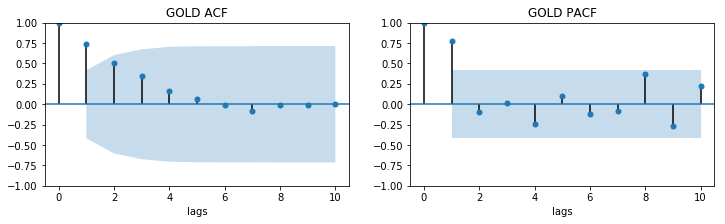

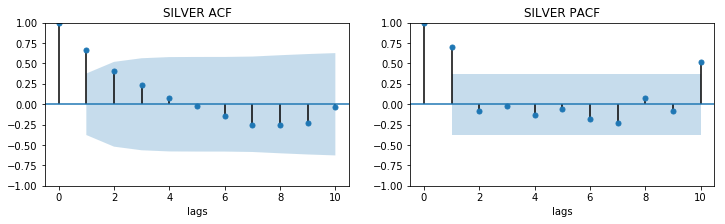

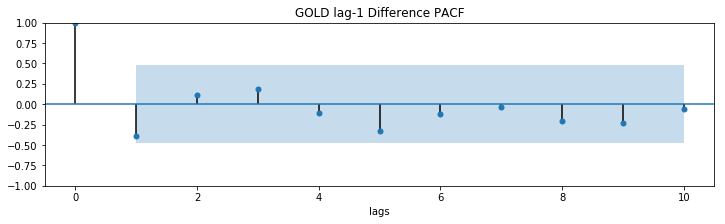

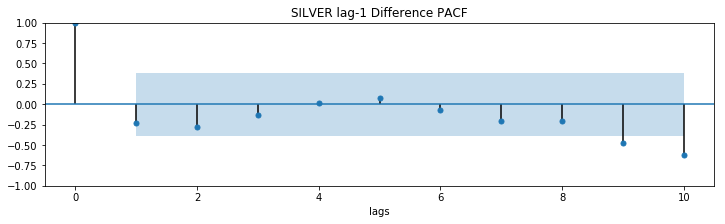

In [115]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib import pyplot
class counter(object): # subplot index counter
    def __init__(self,init):
        self.i=init
    def count(self):
        self.i+=1
        return self.i
    
def predictability(y,commodity,doacf,dopacf):
    maxlag = 10
    isub=counter(100+(doacf+dopacf)*10) # subplot index
    fig = pyplot.figure(figsize=(12,3))
#    pyplot.suptitle(commodity) if (doacf+dopacf)>1 else pyplot.suptitle(commodity)
    if doacf:
        ax = fig.add_subplot(isub.count())
        fig = plot_acf(y,lags=maxlag,ax=ax)
        ax.set_title(commodity+' ACF')
        pyplot.ylim(-1,1)
        pyplot.xlabel('lags')
    if dopacf:
        ax = fig.add_subplot(isub.count())
        fig = plot_pacf(y,lags=maxlag,ax=ax)
        ax.set_title(commodity+' PACF')
        pyplot.ylim(-1,1)
        pyplot.xlabel('lags')
    pyplot.show()

class lag_differencing(object):
    def __init__(self,data,lags,commodity):
        self.data = data
        self.lags = lags
        self.commodity=commodity
    def dataframe(self):
        data = self.data[self.commodity].iloc[self.lags:].values-self.data[self.commodity].iloc[:-self.lags].values
        data = data[~np.isnan(data)]
        return data
    def numpyarray(self):
        data = self.data[self.lags:] - self.data[:-self.lags] 
        return data
# If past pricec are good predictors of future price
predictability(gold_price,'GOLD',1,1)    
predictability(silver_price,'SILVER',1,1)

# If the price difference (increase or decrease) is predictable
d1_gold   = lag_differencing(df,1,'gold').dataframe()
d1_silver = lag_differencing(df,1,'silver').dataframe()
predictability(d1_gold,'GOLD lag-1 Difference',0,1)
predictability(d1_silver,'SILVER lag-1 Difference',0,1)


* Predictability of price
> Top two figures show little partial autocorrelation after lag-1. Therefore the ACF memories from lag-2 and lag-3 are just the memory propagated from lag-1, which suggests an AR1 model for both the gold and silver price prediction.

* Pedictability of price increase or decrease
> There are no lag correlations in the bottom two figures, so there are no day-to-day predictability to the price difference.

# Long term predictability: seasonality and trend


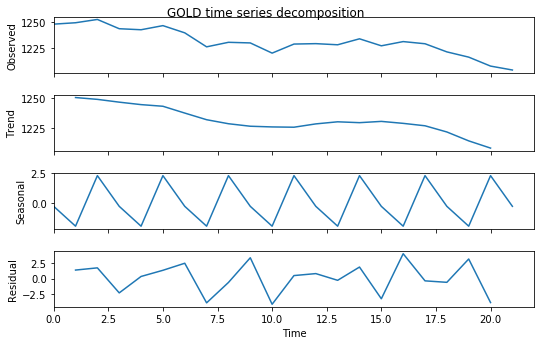

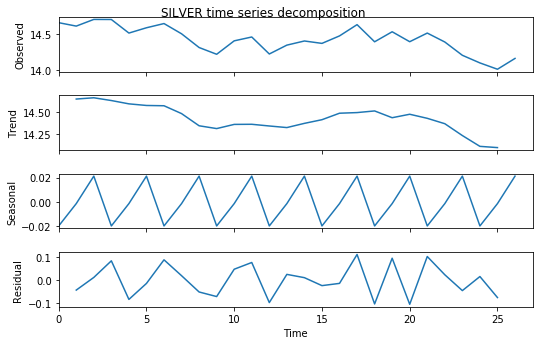

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
gold_decomp = seasonal_decompose(gold_price, model='additive',freq=3) # 365 is the sampling freq (N/T) in a period T=year
silver_decomp = seasonal_decompose(silver_price, model='additive',freq=3) # 365 is the sampling freq (N/T) in a period T=year
# additive model: y[t] = T[t] + S[t] + resid[t]
# seasonal part is filtered out to obtain trend by scipy.signal.convolve, 
# which uses either `direct` or `fft` whichever's faster.
# direct convolution is y(n) = \sum_k x(k)h(n-k), with any given filter h(t), it's directly centering the filter on 
# the point of interest.
fig = gold_decomp.plot()
fig.suptitle('GOLD time series decomposition')
fig.set_size_inches(8,5)
fig = silver_decomp.plot()
fig.suptitle('SILVER time series decomposition')
fig.set_size_inches(8,5)
pyplot.show()

For both commodities, the decomposition shows that there is a 3 days period of seasonal cycle and a downward trend that can be included in the ARIMA model.

# Stationarity Test
Augmented Dickey-Fuller (ADF) test determines if a time series shows stationarity after removing trend (first differencing) and seasonality (seasonal differencing), and the combined.

GOLD
ADF Statistic: -0.491594
p-value: 0.893646
Critical Values:
	10%: -2.749
	5%: -3.233
	1%: -4.332


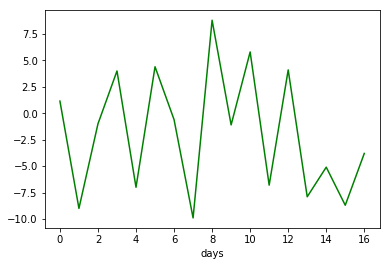

SILVER
ADF Statistic: -3.921337
p-value: 0.001883
Critical Values:
	10%: -2.674
	5%: -3.068
	1%: -3.924


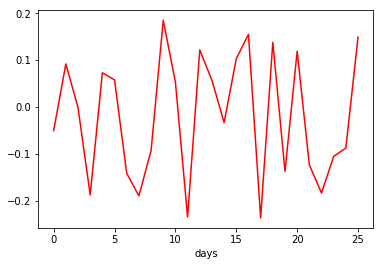

In [99]:
def print_adf(rv,commodity):
    '''
    rv: random variable
    '''
    adf = adfuller(rv)
    print(commodity)
    print('ADF Statistic: %f' % adf[0])
    print('p-value: %f' % adf[1])
    print('Critical Values:')
    for key, value in adf[4].items():
        print('\t%s: %.3f' % (key, value))
    return adf
#adf_gold=print_adf(gold_price,'GOLD')
#pyplot.plot(gold_price,'g'); pyplot.show()
adf1_gold=print_adf(d1_gold,'GOLD')
pyplot.plot(d1_gold,'g'); pyplot.xlabel('days'); pyplot.show()
adf1_silver=print_adf(d1_silver,'SILVER')
pyplot.plot(d1_silver,'r'); pyplot.xlabel('days'); pyplot.show()


This shows that detrending makes silver stationary! 

As for gold, the non-stationarity is due to the samples after 9-days (downward trend)! 

Taking just the first 9-dyas samples will make ADF statistics significant. But this may just be an artifact of NaN days removal. Let's see what the original time series of gold looks like: 

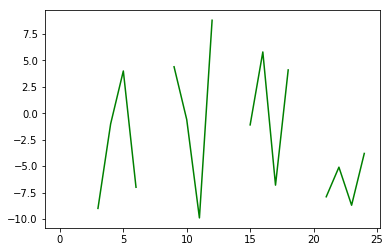

In [101]:
pyplot.plot(df['gold'].iloc[1:].values-df['gold'].iloc[:-1].values,'g')

The lack of continuity certainly is the culprit here! It's makes little sense to analyze the gold price stationarity!

Therefore, below is just the silver price for seasonality stationarity test:

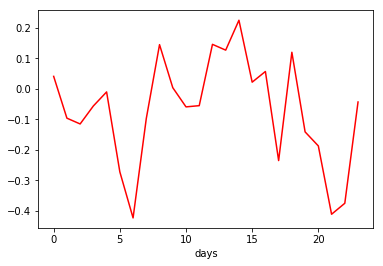

SILVER
ADF Statistic: -3.429135
p-value: 0.010005
Critical Values:
	10%: -2.682
	5%: -3.085
	1%: -3.964


In [117]:
d3_silver=lag_differencing(df,3,'silver').dataframe() # lag-3 is the seasonal period
pyplot.plot(d3_silver,'r'); pyplot.xlabel('days'); pyplot.show()
adf3_silver=print_adf(d3_silver,'SILVER')

Indeed the silver price shows seasonal stationarity! We can move on by combining both detrending and deseasonality:

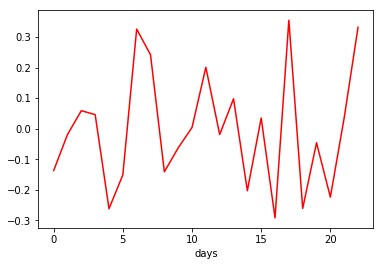

SILVER
ADF Statistic: -3.480621
p-value: 0.008499
Critical Values:
	10%: -2.702
	5%: -3.127
	1%: -4.069


In [118]:
d1d3_silver=lag_differencing(d1_silver,3,'silver').numpyarray() # lag-3 is the seasonal period
pyplot.plot(d1d3_silver,'r'); pyplot.xlabel('days'); pyplot.show()
adf3_silver=print_adf(d1d3_silver,'SILVER')

Both detrending and deseaonality combined shows stationarity! 

An SARIMAX model can easiliy be built based on this EDA!

# Summary
* Web scraping is done more effectively by `lxml` when `XPath` is known.
* Python codes with `sys.argv` shows convenience as a command line expression.
* The commodity time series are characterized by partial autocorrelation and seasonal decomposition.
* Stationarity test shows silver to be both trend and seasonal stationarity, i.e., SARIMA model or LSTM can be built based on the EDA!

# Reference
* [Datetime formate](https://docs.python.org/3/library/datetime.html)
* [partial autocorrelation explained](https://onlinecourses.science.psu.edu/stat510/node/62/)